# 백테스트 03 - 백테스트와 전략 시뮬레이션

<img src="https://i.imgur.com/a8aQaXM.jpg" >
   
### 2019 [FinanceData.KR]()

In [0]:
!pip install -q finance-datareader

In [0]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,8)

# 데이터 준비 

In [3]:
import FinanceDataReader as fdr

# LG전자(066570), 2015~2017년 가격
df = fdr.DataReader('066570', '2015-01-01', '2017-12-31')
df.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2017-12-21,102500,103000,98400,99300,1115976,-0.035922
2017-12-22,100500,101500,99400,100000,591818,0.007049
2017-12-26,101500,102500,99200,99200,934572,-0.008000
2017-12-27,101500,107000,101000,107000,1187463,0.078629
2017-12-28,107000,109500,105000,106000,822274,-0.009346


# 이동평균 전략 백테스트

In [0]:
import pandas as pd
import numpy as np

# 백테스트 DataFrame
df_backtest = pd.DataFrame()

# 시그널 생성
df_backtest['Close'] = df['Close'] 
df_backtest['SHORT_MA'] = df_backtest['Close'].rolling(window=15).mean()
df_backtest['LONG_MA'] = df_backtest['Close'].rolling(window=90).mean()
df_backtest['Signal'] = np.where(df_backtest['SHORT_MA'] > df_backtest['LONG_MA'], 1, 0)

# 수익률
df_backtest['종목수익률'] = np.log(df_backtest['Close'] / df_backtest['Close'].shift(1))
df_backtest['전략수익률'] = df_backtest['Signal'].shift(1) * df_backtest['종목수익률']

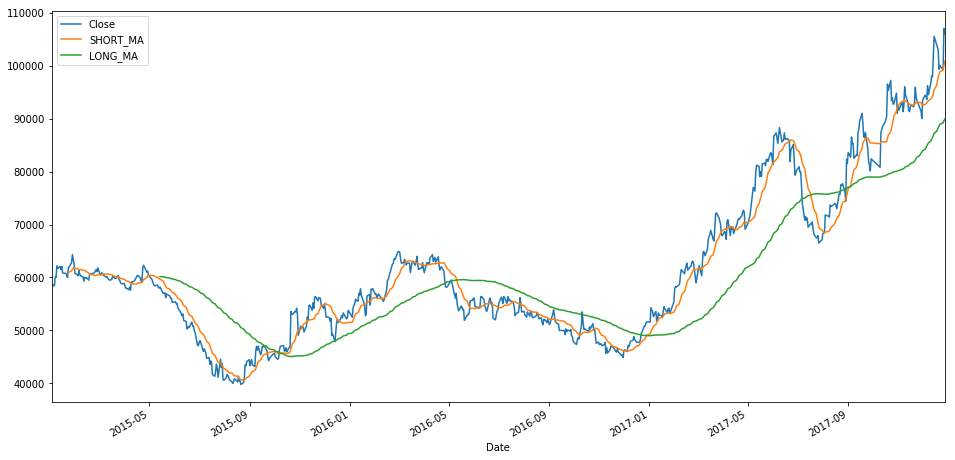

In [5]:
fig, ax = plt.subplots()
df_backtest[['Close', 'SHORT_MA', 'LONG_MA']].plot(ax=ax)

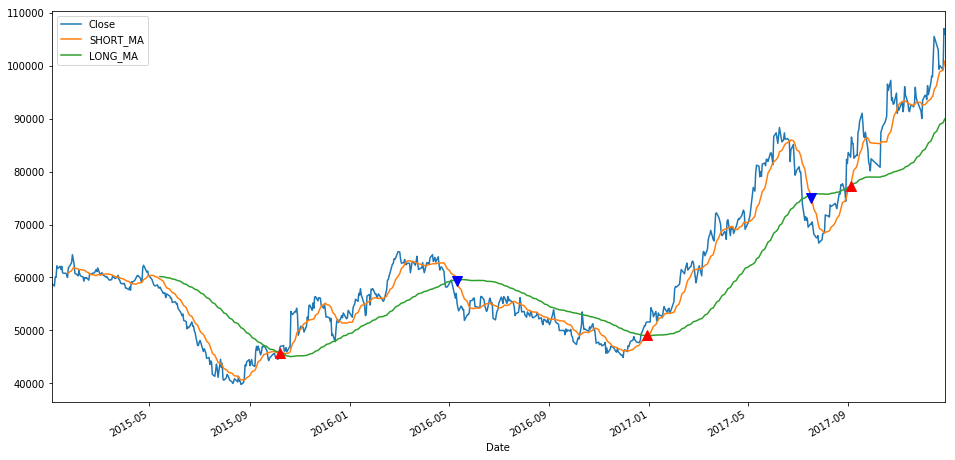

In [6]:
fig, ax = plt.subplots()
   
df_backtest[['Close', 'SHORT_MA', 'LONG_MA']].plot(ax=ax)
df_backtest.loc[df_backtest['Signal'].diff() == 1.0]['SHORT_MA'].plot(ax=ax, marker='^', lw=0, markersize=10, color='r')
df_backtest.loc[df_backtest['Signal'].diff() == -1.0]['SHORT_MA'].plot(ax=ax, marker='v', lw=0, markersize=10, color='b')

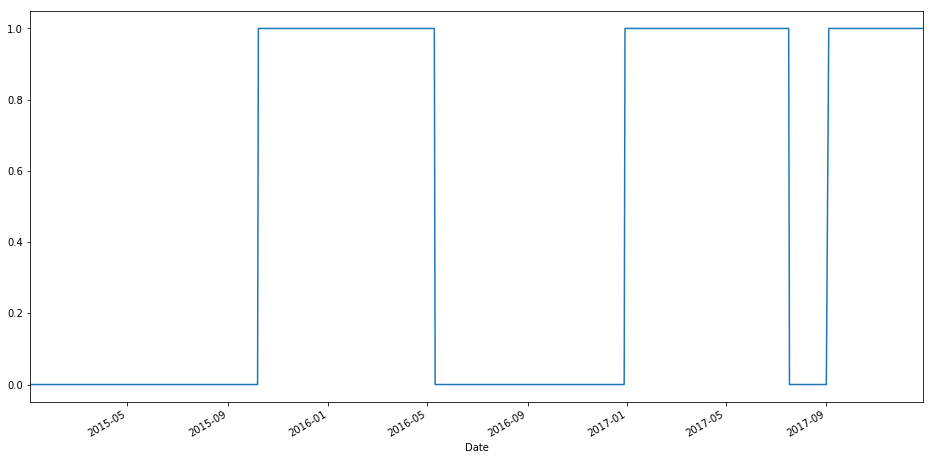

In [7]:
df_backtest['Signal'].plot()

In [8]:
df_backtest['Signal'].diff().value_counts()

 0.0    731
 1.0      3
-1.0      2
Name: Signal, dtype: int64

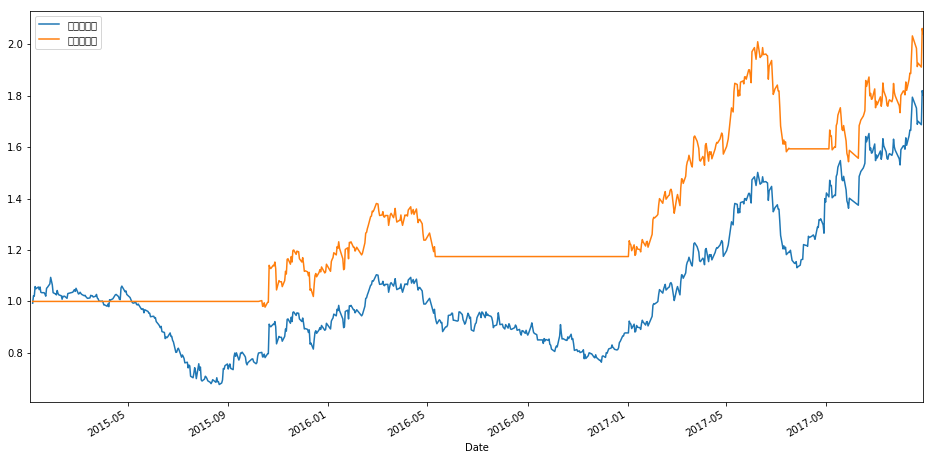

In [9]:
df_backtest[['종목수익률', '전략수익률']].cumsum().apply(np.exp).plot()

In [10]:
df_backtest[['종목수익률', '전략수익률']].cumsum().apply(np.exp).iloc[-1]

종목수익률    1.802721
전략수익률    2.042161
Name: 2017-12-28 00:00:00, dtype: float64

In [11]:
df_backtest[['종목수익률', '전략수익률']].cumsum().apply(np.exp).iloc[-1]['전략수익률']

2.042160698398375

# 전략 시뮬레이션

시간(범위), 단기 이평, 장기 이평을 조합하여 누적 수익률 순으로 결과를 추출

In [12]:
# 조합 생성하기

import itertools

for v in itertools.product([10, 20, 30, 40], [70, 80]):
    print(v)

(10, 70)
(10, 80)
(20, 70)
(20, 80)
(30, 70)
(30, 80)
(40, 70)
(40, 80)


In [13]:
import FinanceDataReader as fdr
import numpy as np
import pandas as pd
import sqlite3
import itertools

# params
code = '066570'
start, end = '2015-01-01', '2018-12-31'
short_ranage = [5, 10, 15, 20]
long_ranage = [25, 30, 60, 90, 120]

# 가격 데이터
df_price = fdr.DataReader(code, start, end)

# 단기 이평, 장기 이평 조합
result_list = []
for v in  itertools.product(short_ranage, long_ranage):
    SHORT_MA, LONG_MA = v

    # 시그널 생성
    df_backtest = pd.DataFrame()
    df_backtest['Close'] = df_price['Close'] 
    df_backtest['SHORT_MA'] = df_backtest['Close'].rolling(window=SHORT_MA).mean()
    df_backtest['LONG_MA'] = df_backtest['Close'].rolling(window=LONG_MA).mean()
    df_backtest['Signal'] = np.where(df_backtest['SHORT_MA'] > df_backtest['LONG_MA'], 1, 0)

    # 수익률
    df_backtest['종목수익률'] = np.log(df_backtest['Close'] / df_backtest['Close'].shift(1))
    df_backtest['전략수익률'] = df_backtest['Signal'].shift(1) * df_backtest['종목수익률']
    
    # 누적 수익률
    cum_returns = df_backtest['전략수익률'].cumsum().apply(np.exp)[-1] - 1.0
    result_list.append([SHORT_MA, LONG_MA, cum_returns])

df_result = pd.DataFrame(result_list, columns=['short_ma', 'long_ma', 'cum_returns'])
df_result.head()

,short_ma,long_ma,cum_returns
0,5,25,1.119371
1,5,30,1.102073
2,5,60,1.188042
3,5,90,1.365453
4,5,120,0.942168


In [14]:
df_result = df_result.sort_values('cum_returns', ascending=False)
df_result.head(20)

,short_ma,long_ma,cum_returns
16,20,30,1.462169
6,10,30,1.382380
3,5,90,1.365453
15,20,25,1.245238
2,5,60,1.188042
11,15,30,1.144908
8,10,90,1.135934
0,5,25,1.119371
1,5,30,1.102073
7,10,60,1.062429


# 리뷰

별도 DataFrame 생성
```python
df_backtest = pd.DataFrame()
df_backtest['Close'] = 종가
df_backtest['MA'] = df_backtest['Close'].rolling(n).mean()
```
시그널(signal)
```python
df_backtest['Signal'] = 1:보유, 0:미보유
```
종목수익률, 전략수익률
```python
df_backtest['종목수익률'] = np.log(df_backtest['Close'] / df_backtest['Close'].shift(1))
df_backtest['전략수익률'] = df_backtest['Signal'].shift(1) * df_backtest['종목수익률']
```    

### 2019 [FinanceData.KR]()